In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def change_range(input_array, min_output, max_output, min_input=None, max_input=None):

    if min_input is not None and max_input is not None:
        input_array = np.clip(input_array, min_input, max_input)
    else:
        min_input = np.min(input_array)
        max_input = np.max(input_array)
    
    output_array = (input_array - min_input)/(max_input - min_input)
    output_array = output_array * (max_output - min_output) + min_output
    return output_array

## Histogram Processing

* Histogram Equalization
* Histogram Matching
* Exact Histogram Matching

### Histogram Equalization

The PDF of intensity values r:
$$p_r(r)$$

The PDF of intensity values s:
$$p_s(s)$$

The transformation:
$$s=T(r)$$

Then the PDF of the transformed variable $s$ can be obtained as
$$p_s(s)=p_r(r)|\frac{dr}{ds}|$$ 

**Define a transformation:**

$$ s = T(r) = (L-1)\int^r_0p_r(\omega)d\omega,$$

where $\omega$ is a dummy variable of integration.

The transformation satisfies two conditions:

* the transformation is a monotonic increasing function in the interval $0 \leq r \leq L-1$
* $0\leq T(r) \leq L-1$ for $0 \leq r \leq L-1$

Obtain

$$\begin{split} \frac{ds}{dr} &=\frac{dT(r)}{dr}\\ &=(L-1)\frac{d}{dr}[\int_0^r p_r(\omega)d\omega]\\ &=(L-1)p_r(r)  \end{split}$$

Then

$$\begin{split} p_s(s) &=p_r(r)|\frac{dr}{ds}|\\ &=p_r(r)|\frac{1}{(L-1)p_r(r)}|\\ &=\frac{1}{L-1} \end{split}$$

the $p_s(s)$ is a uniform probability density function, which is independently of the form of $p_r(r)$

##### Discrete

For discrete values

$$p_r(r_k) = \frac{n_k}{MN},$$

where MN is the total number of pixels in the image, and $n_k$ denotes the number of pixels that have intensity $r_k$.

The discrete form of the transformation is

$$s_k = T(r_k) = (L-1)\sum_{j=0}^kp_r(r_j), \ k = 0, 1, 2, \cdots, L-1$$

##### procedure

1. Obtain $p_r(r_k)$
2. cal $s_k$ 
3. mapping

In [3]:
def cal_histogram_equalization_map(input_image):
    # cal p(rk)
    pixs_count = Counter(input_image.flatten())
    map_list = np.zeros(256)
    if 0 in pixs_count:
        map_list[0] = pixs_count[0]
    
    for i in range(1, 256):
        if i in pixs_count:
            map_list[i] = map_list[i-1] + pixs_count[i]
        else:
            map_list[i] = map_list[i-1]

    MN = np.shape(input_image)[0]*np.shape(input_image)[1]
    map_list = (map_list / MN) * 255

    key_list = np.linspace(0, 255, num=256, dtype=np.int32)

    map_dict = dict(zip(key_list, map_list.astype(np.int32)))

    return map_dict

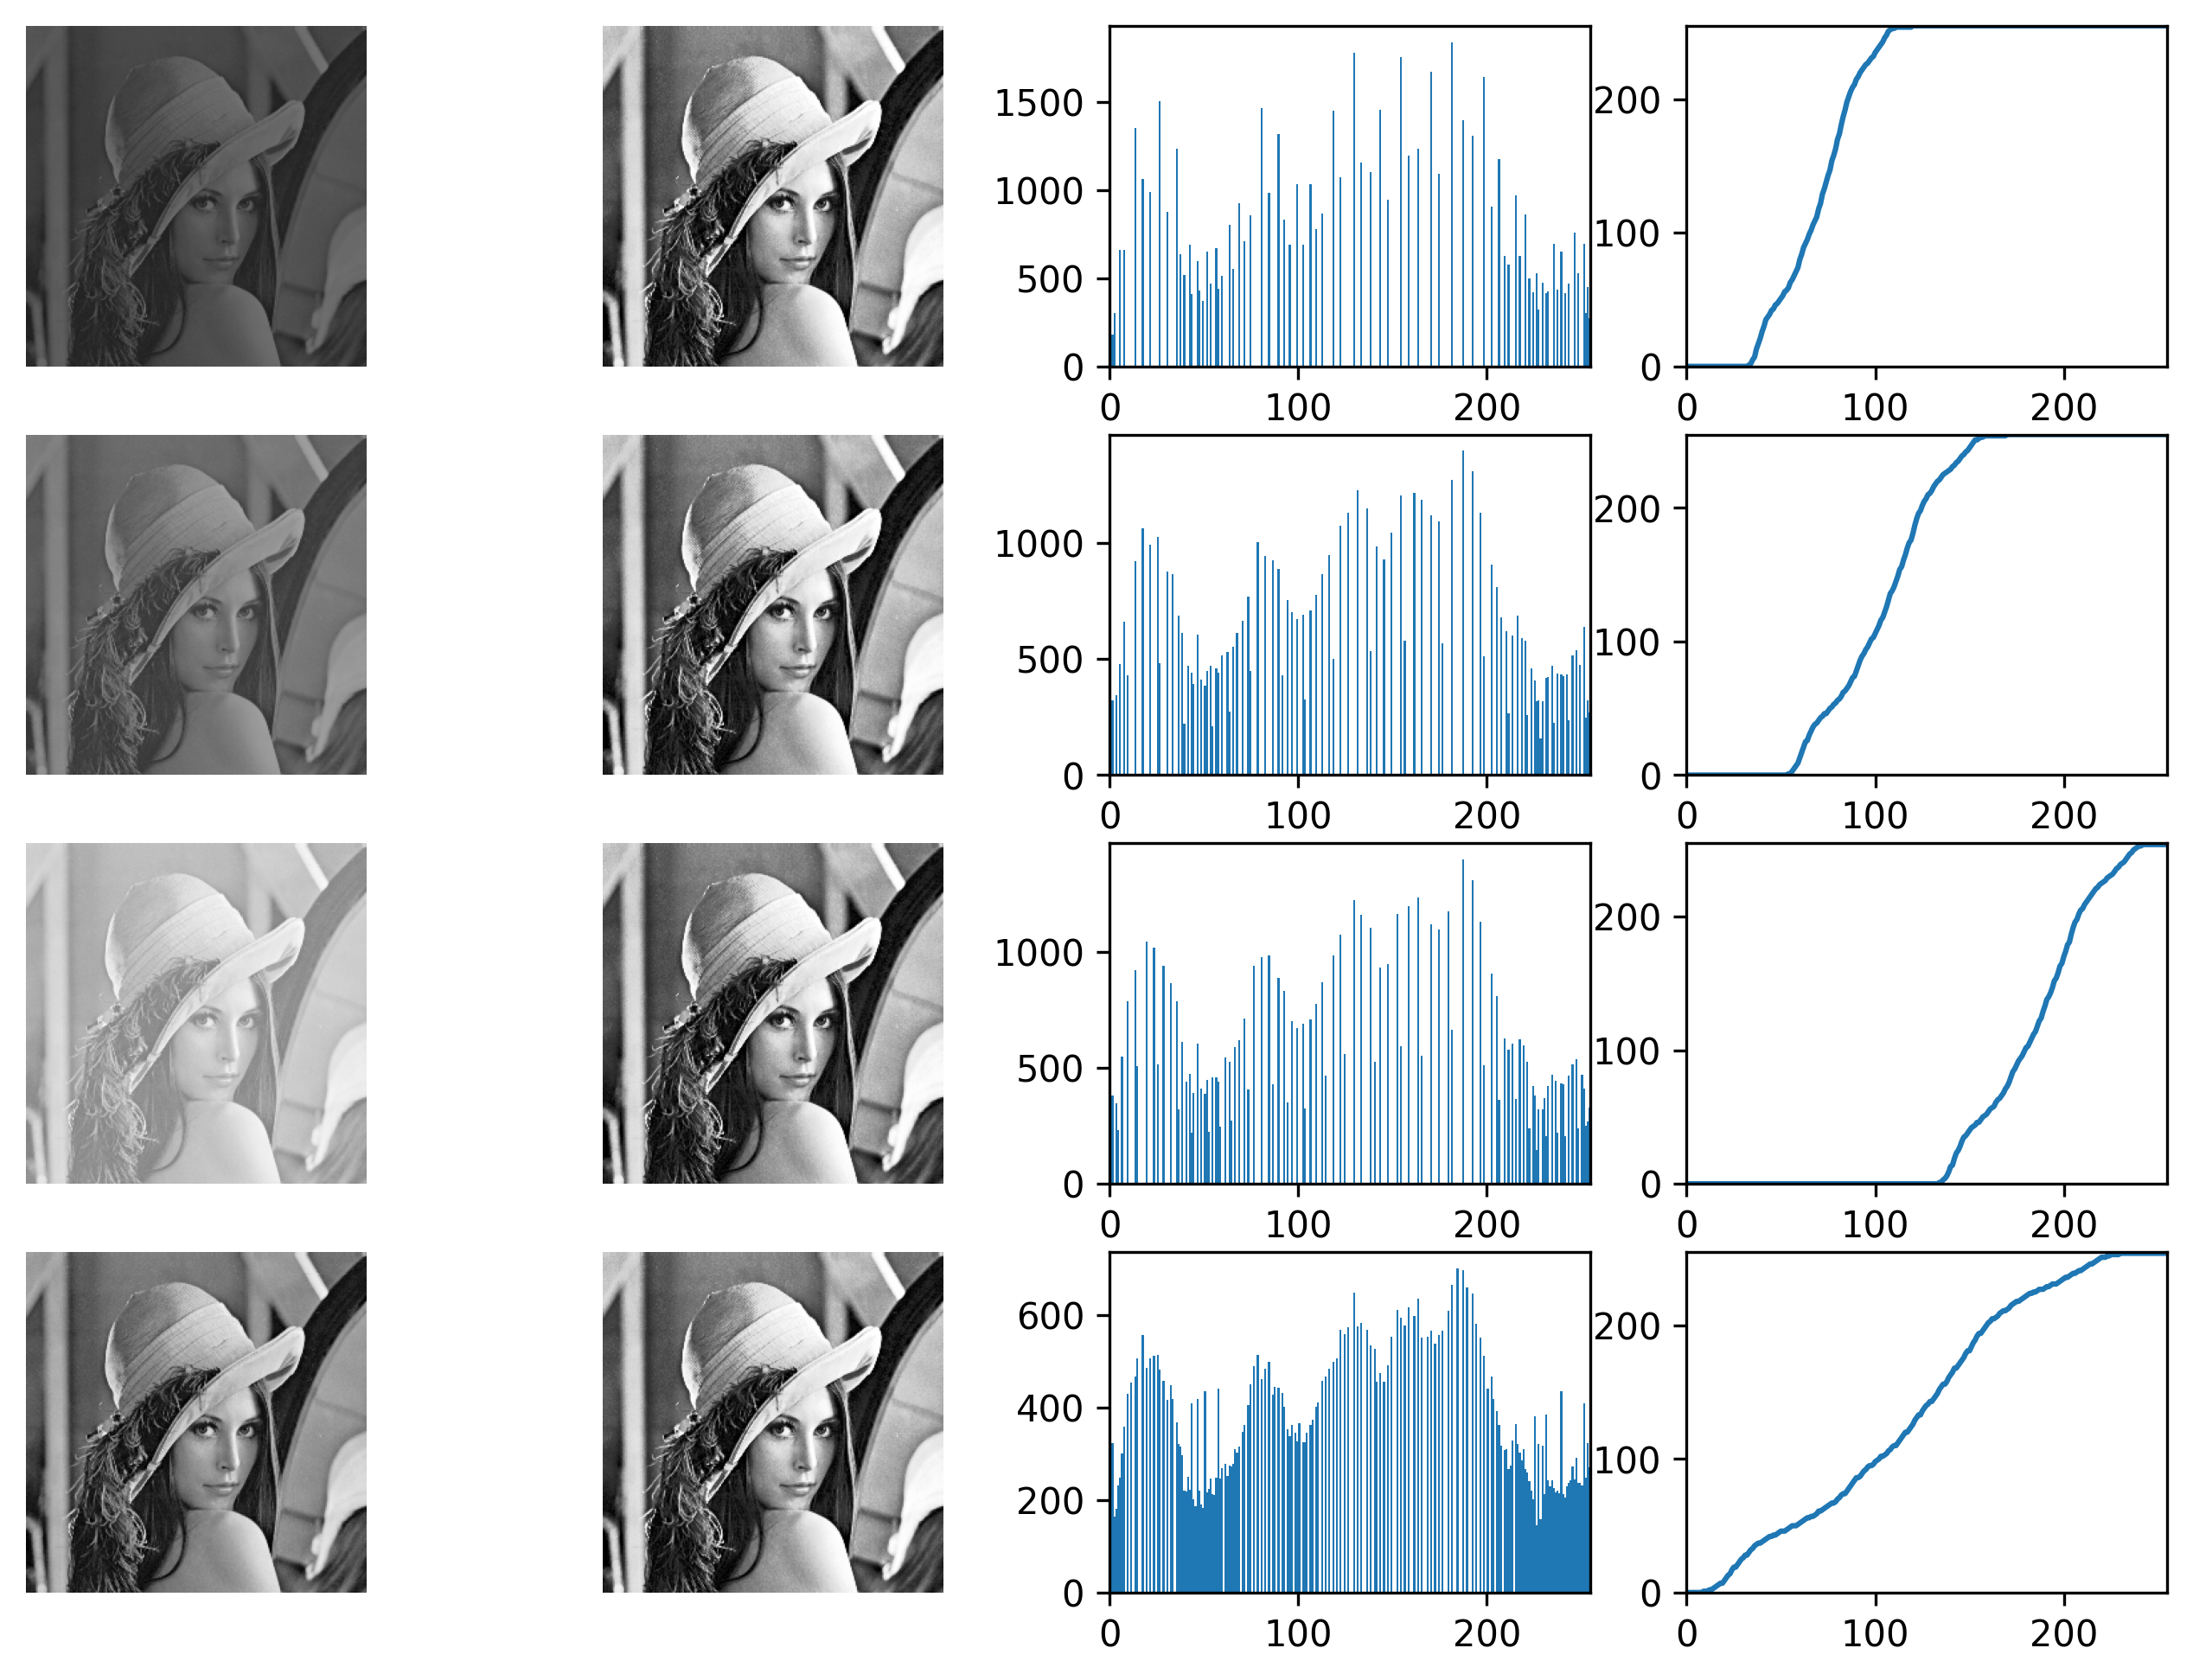

In [5]:
def histogram_equalization(input_image):
    _map_dict = cal_histogram_equalization_map(input_image)
    image_equalization = np.vectorize(_map_dict.get)(input_image)
    return image_equalization, _map_dict

# read image
lena_image = cv2.imread("./images/lena_gray_256.tif", 0)

nerrows_list = [[30, 120], [50, 170], [130, 255], [0, 255]]

indensity_list = np.linspace(0, 255, num=256, dtype=np.int32)

plt.figure(figsize=(11, 8), dpi=300)

for ind, nerrow_setting in enumerate(nerrows_list):
    lena_nerrow = change_range(lena_image, nerrow_setting[0], nerrow_setting[1]).astype(np.uint8)

    lena_equalization, lena_map_dict = histogram_equalization(lena_nerrow)

    plt.subplot(4, 4, ind*4 + 1)
    plt.axis("off")
    plt.imshow(lena_nerrow, cmap="gray", vmin=0, vmax=255)
    plt.subplot(4, 4, ind*4 + 2)
    plt.axis("off")
    plt.imshow(lena_equalization, cmap="gray", vmin=0, vmax=255)
    plt.subplot(4, 4, ind*4 + 3)
    plt.xlim([0, 255])
    plt.hist(lena_equalization.ravel(), 256, [0, 256])
    plt.subplot(4, 4, ind*4 + 4)
    plt.xlim([0, 255])
    plt.ylim([0, 255])
    plt.plot(indensity_list, list(lena_map_dict.values()))

plt.show()

Histogram equalizaiton will spread the histogram over the full range of intensities. The transformation (4) is nearly linear, indicating that the inputs were mapped to nearly equal outputs, anthe first three results from top to bottom show significant improvement.

### Histogram Matching (Specification)

Histogram equalization produces a transformation function that seeks to generate an output image with a uniform histogram.

However, there are applications in which histogram equalization is not suitable. Sometimes, it is useful to be able to specify the shape of the histogram that we wish the processed image to have.

**Definition**
Histogram matching: the method used to generate images that have a specified histogram.

Suppose:

The PDF of intensity value $r$
$$p_r(r)$$
The PDF of intensity value $z$
$$p_z(z)$$
The PDF of intensity value $s_1$
$$p_{s_1}(s_1)$$
The PDF of intensity value $s_2$
$$p_{s_2}(s_2)$$

where $r$ is the intensity value of input image, $z$ is the intensity value of reference image, $s_1$ is the intensity value of input image after histogram equalization, and $s_2$ is the intensity value of reference image after histogram equalization.

Obtain

$$s_1 = T(r) = (L-1)\int_0^rp_r(w)dw$$

$$s_2 = G(z) = (L-1)\int_0^zp_z(v)dv$$

Because 
$$p_{s_1}(s_1) = \frac{1}{L-1}$$
$$p_{s_2}(s_2) = \frac{1}{L-1}$$

Obtain
$$T(r) = G(z)$$

and

$$\begin{split} z &= G^{-1}(s_2)\\ &= G^{-1}(s_1)\\ &=G^{-1}[T(r)]\\ &=G^{-1}[(L-1)\int_0^rp_r(w)dw] \end{split}$$

**Procedure**

1. Obtain $T(r)$ and $G(z)$
2. Computer the inverse transformation $z=G^{-1}(s)=G^{-1}(T(r))$. For each pixel with value r in the input image, perform the mapping $z=G^{-1}(T(r))$ to obtain the corresponding pixel in the output image.


**Discrete**
$$s_{1k} = T(r_k) = (L-1)\sum_{j=0}^kp_r(r_j), \ k = 0, 1, 2, \cdots, L-1$$

$$s_{2k} = G(z_q) = (L-1)\sum_{j=0}^qp_z(z_j), \ q = 0, 1, 2, \cdots, L-1$$

$$\begin{split} z_q &= G^{-1}(s_{2k})\\ &=G^{-1}(s_{1k})\\ &= G^{-1}((L-1)\sum_{j=0}^kp_r(r_j))  \end{split}$$

In [59]:
def cal_histogram_matching_specification_map(input_image, refer_image):
    # cal map r to s_1
    input_equalization_map = cal_histogram_equalization_map(input_image)
    # cal map z to s_2
    refer_equalization_map = cal_histogram_equalization_map(refer_image)
    s_2_list = list(refer_equalization_map.values())

    # cal map s_2 to z
    
    map_matrix = np.linspace(0, 255, 256)
    map_matrix = np.expand_dims(map_matrix, 1).repeat(len(s_2_list), axis=1)
    s_2_list = np.expand_dims(s_2_list, 0).repeat(256, axis=0)
    map_matrix -= s_2_list
    
    s_2_z_map_dict = dict(zip(np.linspace(0, 255, 256, dtype=np.int32), np.argmin(np.abs(map_matrix), axis=1)))

    input_list = list(input_equalization_map.keys())
    r_z_map_dict = dict(zip(input_list, np.vectorize(s_2_z_map_dict.get)(list(input_equalization_map.values()))))
    return r_z_map_dict

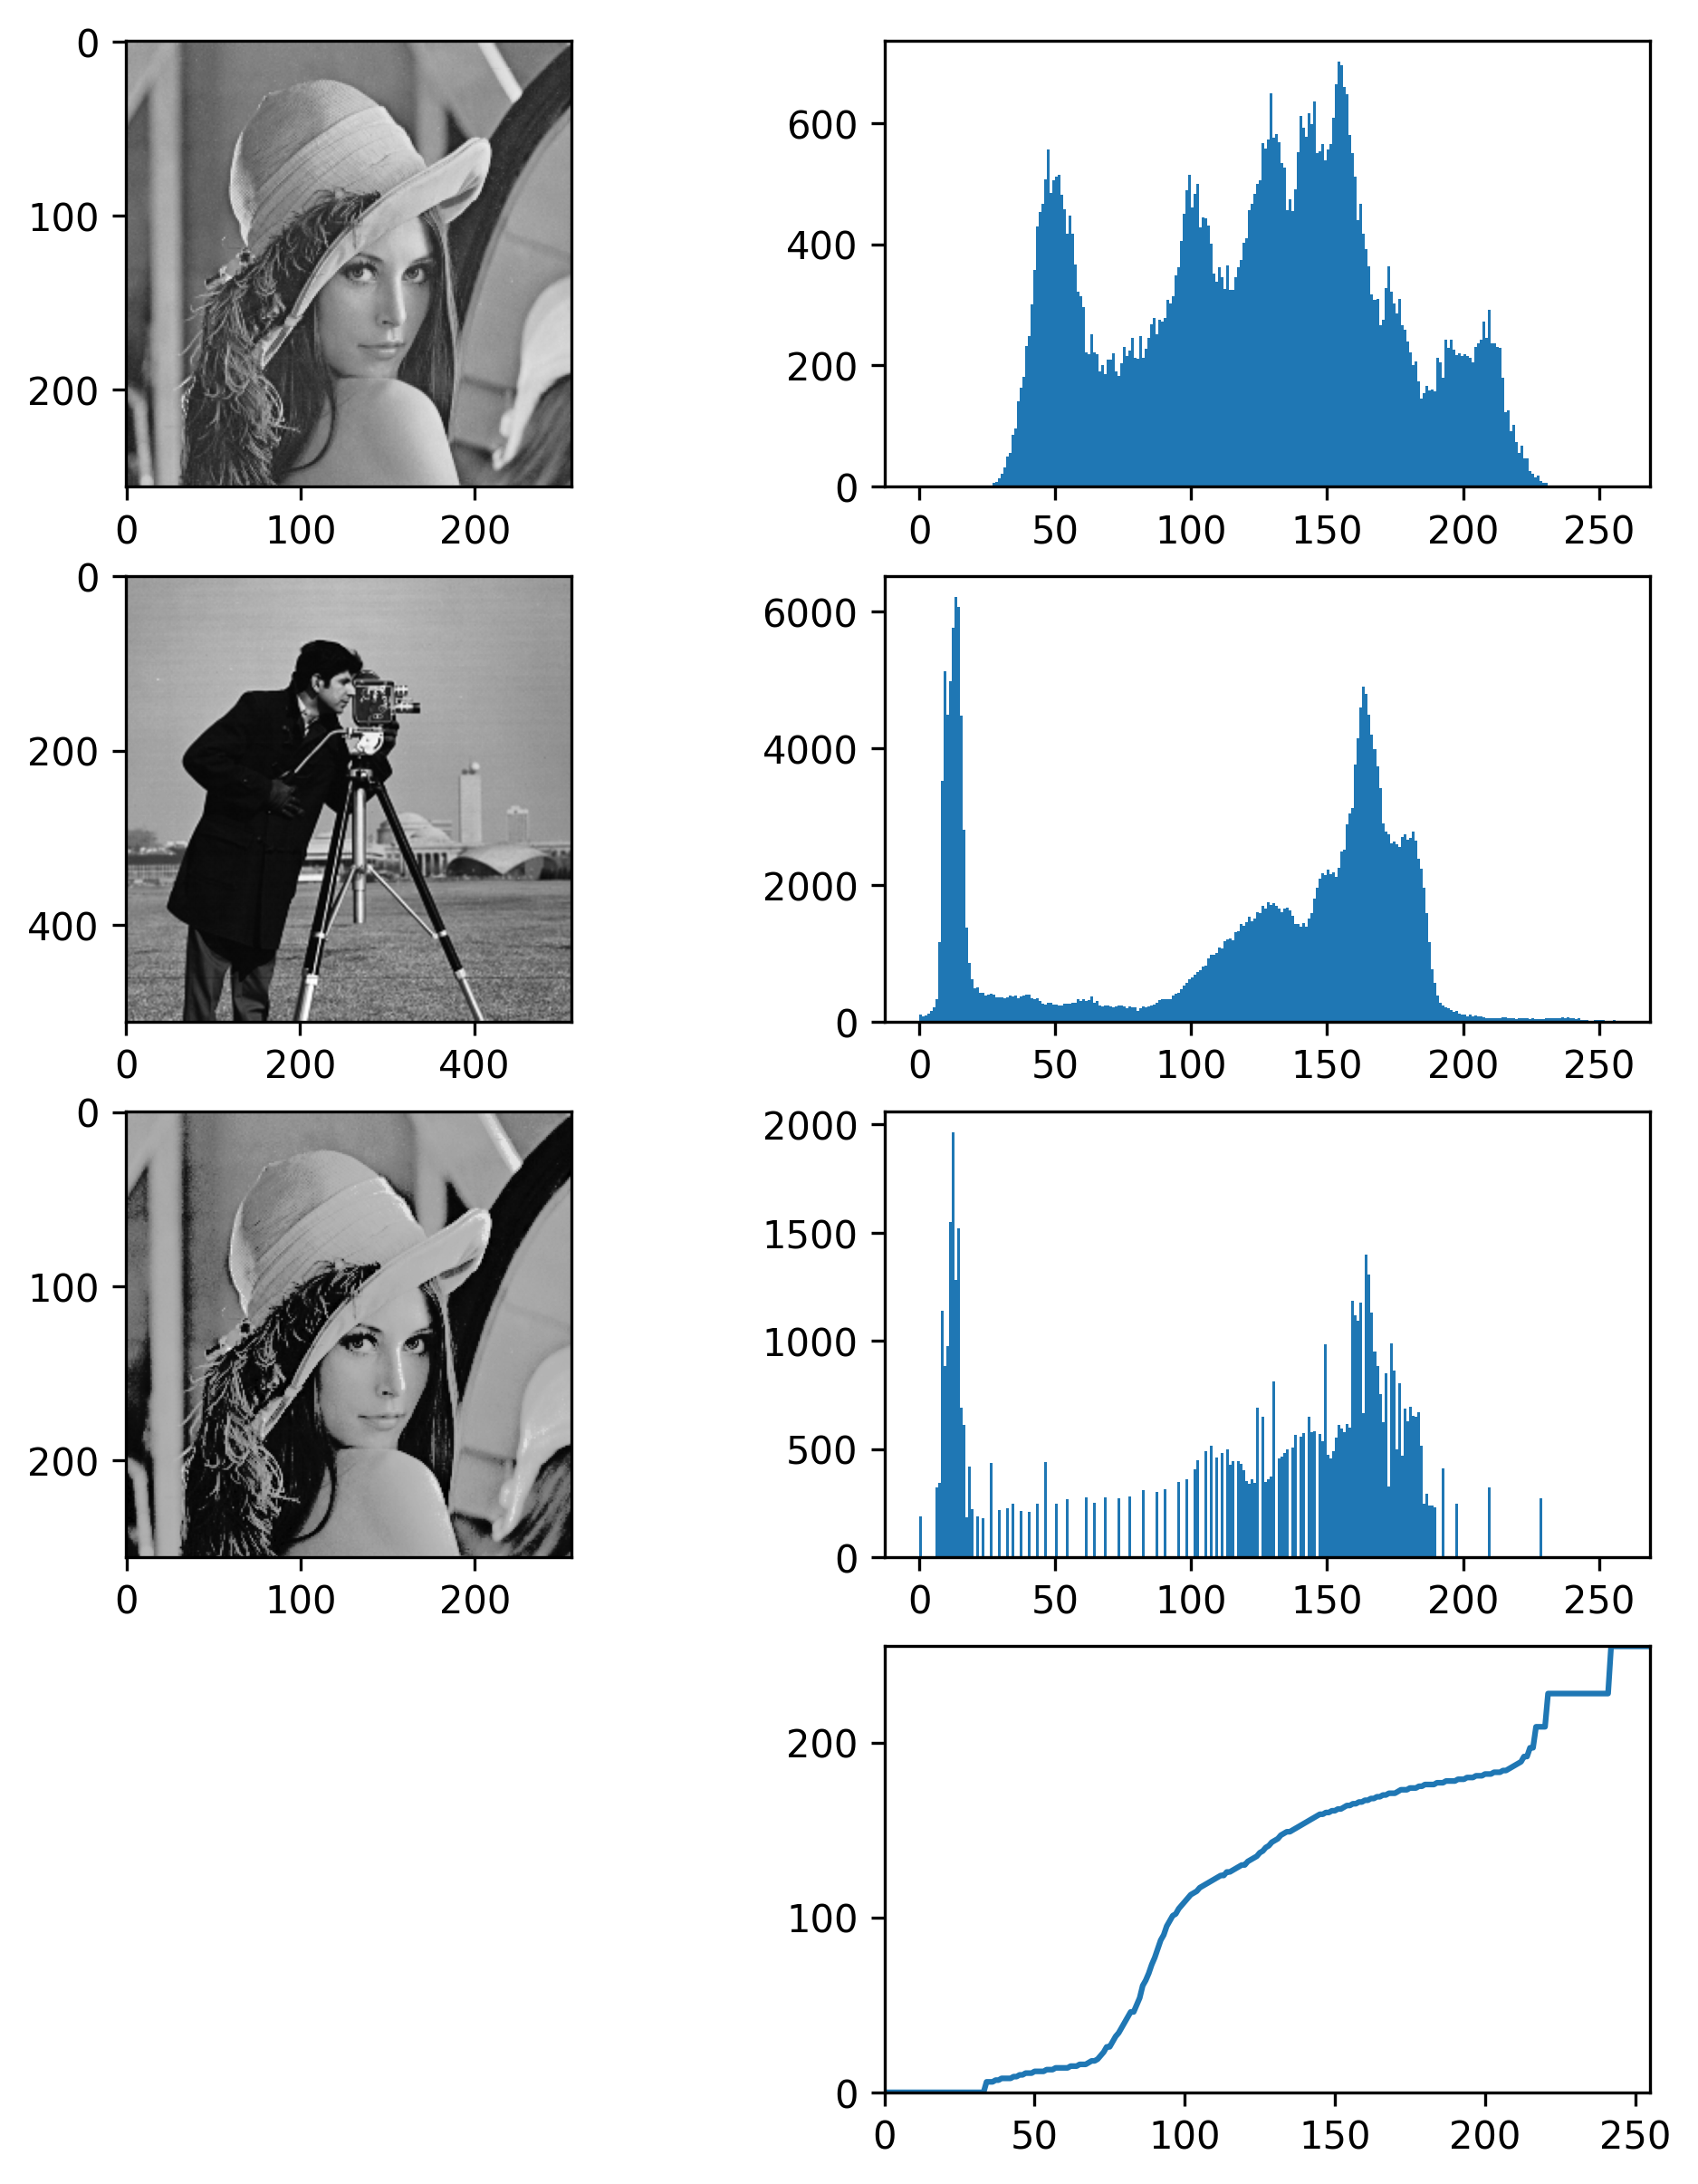

In [68]:
# read image
lena_image = cv2.imread("./images/lena_gray_256.tif", 0)
cameraman_image = cv2.imread("./images/cameraman.tif", 0)

lena_matching_map = cal_histogram_matching_specification_map(lena_image, cameraman_image)

lena_matching_image = np.vectorize(lena_matching_map.get)(lena_image)

plt.figure(figsize=(8, 10), dpi=300)

plt.subplot(4, 2, 1)
plt.imshow(lena_image, cmap="gray", vmin=0, vmax=255)
plt.subplot(4, 2, 2)
plt.hist(lena_image.ravel(), 256, [0, 256])
plt.subplot(4, 2, 3)
plt.imshow(cameraman_image, cmap="gray", vmin=0, vmax=255)
plt.subplot(4, 2, 4)
plt.hist(cameraman_image.ravel(), 256, [0, 256])
plt.subplot(4, 2, 5)
plt.imshow(lena_matching_image, cmap="gray", vmin=0, vmax=255)
plt.subplot(4, 2, 6)
plt.hist(lena_matching_image.ravel(), 256, [0, 256])
plt.subplot(4, 2, 8)
plt.xlim([0, 255])
plt.ylim([0, 255])
plt.plot(np.linspace(0, 255, num=256, dtype=np.int32), list(lena_matching_map.values()))

plt.show()


### Exact Histogram Matching (Specification)

The discrete histogram equalization and specification have no provisions for redistributing the intensities of an image to match a specified shape. The real impact on intensity values by these two methods results from shifting the histogram bins along the intensity scale.

For the histogram of the output image to have an exact specified shape, we have to find a way to **change** and **redistribute** the intensities of the pixels of the input image to create that shape.

#### Define

A specified histogram that we wish a image to have:

$$H = \{ h(0), h(1), \cdots, h(L-1) \}$$

where L is the number of discrete intensity levels, and h(j) is the number of pixels with intensity level $j$. We can get

$$ \sum_{j=0}^{L-1}h(j)=MN $$

where M and N are the number of rows and columns in the image.

#### Procedure

* Order the image pixels according to a predefined criterion.
* Split the ordered pixels into $L$ groups, such that group $j$ has $h(j)$ pixels.
* Assign intensity value $j$ to all pixels in group $j$.

#### Analysis

Usually, $MN$ is mach larger than the number of discrete intensity levels. Thus, a strict ordering of all the pixels in an image usually cannot be achieved on the basis of intensity of individual pixels alone. We need to introduce additional properties.

#### Basic additional properties

If we give each pixel a random constant and ordering these pixels use this parameter, we can get a strict ordering of all the pixels in an image. This ordering does not dependent on intensity values.

#### More meaningful method(**Lexicographical Ordering**)

A logical way to do this is to look for these properties in a neighborhood of each pixel in the image.

**define**

A set of closed neighborhoods centered at coordinates $(x, y)$

$$W_1 \subset W_2 \subset \cdots \subset W_k$$

where $W_i, i=1, 2, \cdots, k$ is a set of closed neighborhoods centered at coordinates $(x, y)$.

Let $a_k(x, y)$ denote the average intensity of the pixels contained in $W_k$, and let $A(x, y)$ denote a *K*-tuple formed by the average intensities in the *K* neighborhoods:
$$A(x, y) = [a_1(x, y), a_2(x, y), \cdots, a_k(x, y)]$$


**Lexicographical Ordering**: 
For any pair of discrete image coordinates $(t, v)$ and $(w, z)$, we say that $A(t, v)$ precedes $A(w, z)$ according to a lexicographical ordering if $a_1(t, v) < a_2(w, z)$, or if there is a $j, 1 \leq j \leq k$, such that $a_i(t, v) = a_i(w, z)$ for $i = 1, 2, \cdots, j-1$ , and $a_j(t, v) < a_j(w, z)$.

#### Neighborhoods centered at coordinates $(x, y)$

$$W_1 = \left[ \begin{array}{cc} 1 \end{array} \right]$$

$$W_2 = \frac{1}{5}\left[ \begin{array}{cc} 0 & 1 & 0 \\ 1 & 1 & 1 \\ 0 & 1 & 0 \end{array} \right]$$

$$W_3 = \frac{1}{9}\left[ \begin{array}{cc} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{array} \right]$$

$$W_4 = \frac{1}{13}\left[ \begin{array}{cc} 0 & 0 & 1 & 0 & 0 \\ 0 & 1 & 1 & 1 & 0 \\ 1 & 1 & 1 & 1 & 1 \\ 0 & 1 & 1 & 1 & 0 \\ 0 & 0 & 1 & 0 & 0 \end{array} \right]$$

$$W_5 = \frac{1}{21}\left[ \begin{array}{cc} 0 & 1 & 1 & 1 & 0 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 0 & 1 & 1 & 1 & 0 \end{array} \right]$$

$$W_6 = \frac{1}{25}\left[ \begin{array}{cc} 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \end{array} \right]$$

#### Exact Histogram Specification Algorithm

1. Specify a histogram $H={h(0), h(1), \cdots, h(L-1)}$ .
2. Specify a value for *K*.
3. Process the input image with *K* averaging kernels, and get *K* average images.
4. Flat the image, get MN elements, and sort by *K* average values.
5. Group the MN elements into L group, such that group *j* has *h(j)* elements.
6. Assign intensity value *j* to all the elements in group *j*, and create map from elements to intensity values.
7. Reconstruct the output image

In [25]:
# group
def exact_histogram_group(sort_index, histogram_dict):
    histogram_static = list(histogram_dict.values())
    histogram_value = list(histogram_dict.keys())

    # cal CDF
    histogram_cdf = np.cumsum(histogram_static)
    # group
    sort_group = np.split(sort_index, histogram_cdf)

    # zip to dict
    histogram_2_index_map = dict(zip(histogram_value, sort_group))
    return histogram_2_index_map

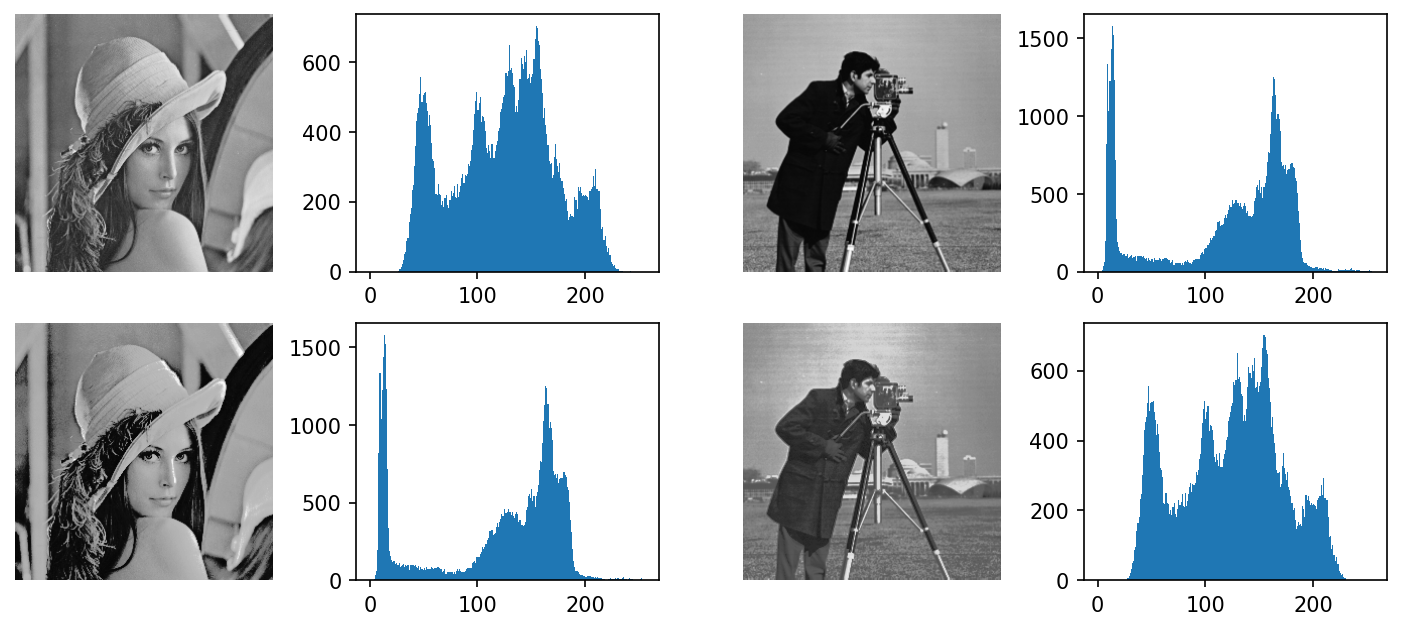

In [30]:
# Random

# read image
lena_image = cv2.imread("./images/lena_gray_256.tif", 0)
cameraman_image = cv2.imread("./images/cameraman.tif", 0)
# resize the refer image
cameraman_image = cv2.resize(cameraman_image, lena_image.shape)

# flatten
lena_shape = np.shape(lena_image)
lena_flatten = np.reshape(lena_image, (-1, 1))

cameraman_shape = np.shape(cameraman_image)
cameraman_flatten = np.reshape(cameraman_image, (-1, 1))

# index
lena_index = np.arange(np.prod(np.shape(lena_image))).astype(np.int32)
cameraman_index = np.arange(np.prod(np.shape(lena_image))).astype(np.int32)

# 0, 1
lena_random_param = np.random.rand(np.prod(np.shape(lena_image)), 1)
cameraman_random_param = np.random.rand(np.prod(np.shape(cameraman_image)), 1)
# 0~256
lena_random_param += lena_flatten
cameraman_random_param += cameraman_flatten

# sort
lena_sort_index = np.argsort(lena_random_param, axis=0)
cameraman_sort_index = np.argsort(cameraman_random_param, axis=0)

# obtain histogram static dict
cameraman_unique, cameraman_counts = np.unique(cameraman_image, return_counts=True)
cameraman_histogram_static_dict = dict(zip(cameraman_unique, cameraman_counts))
lena_unique, lena_counts = np.unique(lena_image, return_counts=True)
lena_histogram_static_dict = dict(zip(lena_unique, lena_counts))

cameraman_value_to_index_map = exact_histogram_group(lena_sort_index, cameraman_histogram_static_dict)
lena_value_to_index_map = exact_histogram_group(cameraman_sort_index, lena_histogram_static_dict)

lena_new_histogram_image = np.zeros_like(lena_flatten)
cameraman_new_histogram_image = np.zeros_like(lena_flatten)

for v in cameraman_value_to_index_map.keys():
    lena_new_histogram_image[cameraman_value_to_index_map[v]] = v
for v in lena_value_to_index_map.keys():
    cameraman_new_histogram_image[lena_value_to_index_map[v]] = v

# reconstruct
lena_new_histogram_image = np.reshape(lena_new_histogram_image, lena_shape)
cameraman_new_histogram_image = np.reshape(cameraman_new_histogram_image, lena_shape)

plt.figure(figsize=(12, 5), dpi=150)

plt.subplot(2, 4, 1)
plt.axis("off")
plt.imshow(lena_image, cmap="gray", vmin=0, vmax=255)
plt.subplot(2, 4, 2)
plt.hist(lena_image.ravel(), 256, [0, 256])
plt.subplot(2, 4, 3)
plt.axis("off")
plt.imshow(cameraman_image, cmap="gray", vmin=0, vmax=255)
plt.subplot(2, 4, 4)
plt.hist(cameraman_image.ravel(), 256, [0, 256])
plt.subplot(2, 4, 5)
plt.axis("off")
plt.imshow(lena_new_histogram_image, cmap="gray", vmin=0, vmax=255)
plt.subplot(2, 4, 6)
plt.hist(lena_new_histogram_image.ravel(), 256, [0, 256])
plt.subplot(2, 4, 7)
plt.axis("off")
plt.imshow(cameraman_new_histogram_image, cmap="gray", vmin=0, vmax=255)
plt.subplot(2, 4, 8)
plt.hist(cameraman_new_histogram_image.ravel(), 256, [0, 256])

plt.show()

The Random method seems good, and the histogram of raw image exact matching to the reference image's histogram.

#### **Lexicographical Ordering**

$$W_1 = \left[ \begin{array}{cc} 1 \end{array} \right]$$
256 different intensity values can be distinguished by using $W_1$

$$W_2 = \frac{1}{5}\left[ \begin{array}{cc} 0 & 1 & 0 \\ 1 & 1 & 1 \\ 0 & 1 & 0 \end{array} \right]$$
255*5+1=1276 different intensity values can be distinguished by using $W_2$

$$W_3 = \frac{1}{9}\left[ \begin{array}{cc} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{array} \right]$$
255*9+1=2296 different intensity values can be distinguished by using $W_3$

$$W_4 = \frac{1}{13}\left[ \begin{array}{cc} 0 & 0 & 1 & 0 & 0 \\ 0 & 1 & 1 & 1 & 0 \\ 1 & 1 & 1 & 1 & 1 \\ 0 & 1 & 1 & 1 & 0 \\ 0 & 0 & 1 & 0 & 0 \end{array} \right]$$
255*13+1=2216 different intensity values can be distinguished by using $W_4$

$$W_5 = \frac{1}{21}\left[ \begin{array}{cc} 0 & 1 & 1 & 1 & 0 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 0 & 1 & 1 & 1 & 0 \end{array} \right]$$
255*21+1=5356 different intensity values can be distinguished by using $W_5$

$$W_6 = \frac{1}{25}\left[ \begin{array}{cc} 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \end{array} \right]$$
255*25+1=6376 different intensity values can be distinguished by using $W_6$

If using $W_1$ and $W_2$ , 256 \* (255\*4+1)=261,376 different (x, y) with its neighborhood can be distinguished. about (511, 511) image.

If using $W_1$, $W_2$ and $W_3$ , 256 * (255\*4+1) \* (255\*4+1)=266,864,896 different (x, y) with its neighborhood can be distinguished. about (16336, 16336) image.

**True Exact Histogram Specification Algorithm**:
0. k = 2
1. Check weather all pixels can be distinguished with other pixels
    * if true:
        * over
    * else:
        * k = k+1, and return to 1.